In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pickle
import mysql.connector

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import category_encoders as ce

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
contraseña_moran = 'Deportivo96'
contraseña_carlos = "Whereisbotus1996"

In [5]:
# Funcion para extraer datos
def extraer_datos(nombre_tabla, columna = '*'):
    
    try:
        # Conexión a la base de datos de MySQL
        conn = mysql.connector.connect(
            host = "localhost",
            user = "root",
            password = contraseña_moran,
            database = "coches_segunda_mano"
        )
        # Crear un cursor para ejecutar comandos SQL
        cursor = conn.cursor()

        # Crear la consulta SQL para seleccionar todos los datos de la tabla
        query = f"SELECT {columna} FROM {nombre_tabla}"

        # Ejecutar la consulta y recuperar los datos
        cursor.execute(query)
        resultado = cursor.fetchall()

        # Obtener los nombres de las columnas de la tabla
        columnas = [desc[0] for desc in cursor.description]

        # Convertir los resultados a un DataFrame
        df = pd.DataFrame(resultado, columns=columnas)

        # Cerrar el cursor y la conexión
        cursor.close()
        conn.close()

        # Devolver el DataFrame
        print(f"Datos de {nombre_tabla} extraidos correctamente")
        return df
    
    except mysql.connector.Error as e:
        print(f"Error al conectar con la base de datos: {e}")
        return pd.DataFrame() 
    
    finally:
        # Asegurarse de cerrar la conexión y el cursor
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

In [6]:
df = extraer_datos('vista_prestaciones')

Datos de vista_prestaciones extraidos correctamente


In [7]:
df

,marca,modelo,mes_matriculacion,ano_matriculacion,kilometraje,distintivo_ambiental,garantia,precio_nuevo,precio_contado,concesionario,provincia,comunidad_autonoma,tipo_traccion,largo,ancho,alto,capacidad_maletero,num_plazas,num_puertas,batalla,peso,consumo_medio,consumo_carretera,consumo_urbano,co2,deposito,combustible,num_cilindros,cilindrada,sobrealimentacion,tipo_cambio,num_marchas,potencia_kw,potencia_cv,par,velocidad_max,aceleracion
0,Volkswagen,POLO,10,2019,93000.0,C,12.0,29044.00,20950.00,COCHES AMB,Madrid,Madrid,delantera,4053.0,1751.0,1461.0,355.0,5.0,5.0,2548.0,1855.0,5.80,4.90,7.70,138.00,40.00,Gasolina,4.0,1984.0,Turbo,Automático,6.0,147.0,200.0,320.0,237.0,6.70
1,Opel,CORSA,7,2009,236945.0,B,NaN,15660.00,4000.00,AUTOS CAPRICAR,Madrid,Madrid,delantera,3999.0,1737.0,1488.0,285.0,5.0,5.0,2511.0,1695.0,4.60,3.80,5.90,127.00,45.00,Diesel,4.0,1248.0,Turbo,Manual,6.0,66.0,90.0,200.0,172.0,12.70
2,Skoda,OCTAVIA,8,2017,44300.0,ECO,12.0,25030.00,15900.00,SKOMOVIL MURCIA,Murcia,Murcia,delantera,4670.0,1814.0,1458.0,460.0,5.0,5.0,2680.0,1878.0,5.70,4.60,7.40,101.00,50.00,Gasolina/gas,4.0,1395.0,Turbo,Manual,6.0,81.0,110.0,200.0,195.0,10.90
3,Skoda,KAMIQ,3,2024,10600.0,C,12.0,None,24900.00,SKOMOVIL MURCIA,Murcia,Murcia,None,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,None,None,None,None,None,Gasolina,NaN,NaN,None,Automático,NaN,NaN,110.0,NaN,NaN,None
4,Skoda,OCTAVIA,2,2024,13673.0,0 EMISIONES,12.0,None,33500.00,SKOMOVIL MURCIA,Murcia,Murcia,None,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,None,None,None,None,None,Eléctrico,NaN,NaN,None,Automático,NaN,NaN,204.0,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6447,Lexus,NX,7,2017,136664.0,ECO,NaN,42300.00,8999.00,AUTOPROF,Tarragona,Cataluña,delantera,4630.0,1845.0,1645.0,555.0,5.0,5.0,2660.0,2245.0,5.40,3.70,7.00,119.00,56.00,Híbrido Enchufable,4.0,2494.0,None,Automático,1.0,145.0,197.0,210.0,NaN,9.30
6448,Renault,CLIO,3,2011,270000.0,B,12.0,14115.00,3500.00,AUTOS ERNESTO,Toledo,Castilla-La Mancha,delantera,4027.0,1720.0,1497.0,288.0,5.0,5.0,2575.0,1645.0,4.00,3.50,4.90,106.00,55.00,Diesel,4.0,1461.0,Turbo,Manual,5.0,55.0,75.0,NaN,NaN,None
6449,Bmw,SERIE 5,11,2019,178000.0,C,12.0,55200.00,27999.00,AUTOS E.I.C,Lugo,Galicia,trasera,4936.0,1868.0,1479.0,530.0,5.0,4.0,2975.0,2270.0,4.50,4.10,5.00,117.00,66.00,Diesel,4.0,1995.0,Turbo de geometría variable,Automático,8.0,140.0,190.0,400.0,235.0,7.30
6450,Jeep,WRANGLER,9,2020,23300.0,C,12.0,64163.00,61500.00,Ewagen Classic&Sportcars S.L,Madrid,Madrid,total conectable,4334.0,1894.0,1841.0,141.0,4.0,3.0,2459.0,2404.0,9.00,6.30,11.70,188.00,66.00,Diesel,4.0,2143.0,Turbo de geometría variable,Automático,8.0,147.0,200.0,450.0,NaN,None


In [8]:
#Calcular en porcentaje de nulos
stats = []
for col in df.columns:
    stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    stats_df = pd.DataFrame(stats, columns=['Columna', 'Valores únicos', '% nulos', '% of values in the biggest category', 'tipo'])
stats_df.sort_values('% nulos', ascending=False)

,Columna,Valores únicos,% nulos,% of values in the biggest category,tipo
24,co2,208,56.137632,56.137632,object
23,consumo_urbano,142,56.091135,56.091135,object
22,consumo_carretera,82,56.091135,56.091135,object
21,consumo_medio,114,50.387477,50.387477,object
29,sobrealimentacion,5,34.082455,43.025418,object
28,cilindrada,199,28.115313,28.115313,float64
25,deposito,81,24.364538,24.364538,object
27,num_cilindros,7,23.465592,46.621203,float64
16,capacidad_maletero,357,19.869808,19.869808,float64
35,velocidad_max,137,19.714817,19.714817,float64


In [9]:
df = df.dropna(subset=['precio_contado'])

In [10]:
# Eliminamos las columnas con mayoría de nulos y potencia_kw porque es un cálculo de potencia_cv

df = df.drop(columns=['co2', 'consumo_carretera', 'consumo_urbano', 'consumo_medio', 'sobrealimentacion', 'potencia_kw', 'precio_nuevo'])

In [11]:
columnas_categoricas = ['provincia', 'comunidad_autonoma', 'concesionario', 'distintivo_ambiental','combustible','tipo_cambio', 'tipo_traccion', 'marca', 'modelo', 'num_plazas', 'num_puertas']
columnas_numericas = []

for columna in df.columns: 
    if columna not in columnas_categoricas: 
        columnas_numericas.append(columna)

In [12]:
df[columnas_numericas] = df[columnas_numericas].apply(pd.to_numeric, errors='coerce')
df[columnas_categoricas] = df[columnas_categoricas].replace(['', 'NaN', None], np.nan)

for columna in columnas_categoricas:
    df[columna] = df[columna].astype('category')

## Eliminación outliers

In [15]:
df_sin_outliers = df.copy()

In [16]:
def prueba_outliers_tukey(col, lado_outliers, k=1.5):
    if col not in columnas_numericas:
        print(f'La columna {col} no es numérica o no existe')
        return
    
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    ric = q3 - q1

    if lado_outliers == 'derecho':
        lim_l = df[col].min()
        lim_r = q3 + k * ric

    elif lado_outliers == 'izquierdo':
        lim_l = q1 - k * ric
        lim_r = df[col].max()

    elif lado_outliers == 'ambos':
        lim_l = q1 - k * ric
        lim_r = q3 + k * ric

    else: 
        print(f'No has indicado un lado válido para los outliers. Usa "derecho", "izquierdo", o "ambos".')
        return
    
    porcentaje = df[df[col].between(lim_l, lim_r) | df[col].isna()].shape[0] / df.shape[0] * 100
    print(lim_l, lim_r)
    print(f'Se mantienen el {porcentaje:.2f}% de los datos en la columna {col} después de eliminar los outliers.')
    
    fig = plt.figure(figsize=(14, 6))
    gs = fig.add_gridspec(1, 2)
        
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(df[col], kde=True, ax=ax1)
    plt.axvline(lim_l, color='red')
    plt.axvline(lim_r, color='red')
    ax1.set_title(f'Histograma de {col}')
    ax1.set_xlabel(col)
        
    ax2 = fig.add_subplot(gs[0, 1])
    sns.boxplot(x=df[col], ax=ax2)
    plt.axvline(lim_l, color='red')
    plt.axvline(lim_r, color='red')
    ax2.set_title(f'Boxplot de {col}')
    ax2.set_xlabel(col)
        
    plt.tight_layout()
    plt.show()

In [17]:
def prueba_outliers_z(col, z=3):
    
    if col not in columnas_numericas:
        print(f'La columna {col} no es numérica o no existe')
        
    mean = df[col].mean()
    std = df[col].std()
    
    lim_l = mean - z*std
    lim_r = mean + z*std
    
    porcentaje = df[df[col].between(lim_l, lim_r) | df[col].isna()].shape[0] / df.shape[0] * 100
    print(f'Se mantienen el {porcentaje:.2f}% de los datos en la columna {col} después de eliminar los outliers.')
    
    fig = plt.figure(figsize=(14, 6))
    gs = fig.add_gridspec(1, 2)
        
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(df[col], kde=True, ax=ax1)
    plt.axvline(lim_l, color='red')
    plt.axvline(lim_r, color='red')
    ax1.set_title(f'Histograma de {col}')
    ax1.set_xlabel(col)
        
    ax2 = fig.add_subplot(gs[0, 1])
    sns.boxplot(x=df[col], ax=ax2)
    plt.axvline(lim_l, color='red')
    plt.axvline(lim_r, color='red')
    ax2.set_title(f'Boxplot de {col}')
    ax2.set_xlabel(col)
        
    plt.tight_layout()
    plt.show()

In [18]:
def outliers_tukey(df_sin_outliers, col, lado_outliers, k=1.5):
    
    if col not in columnas_numericas:
        print(f'La columna {col} no es numérica o no existe')

    q1 = df_sin_outliers[col].quantile(0.25)
    q3 = df_sin_outliers[col].quantile(0.75)
    ric = q3 - q1

    if lado_outliers == 'derecho':
        lim_l = df_sin_outliers[col].min()
        lim_r = q3 + k * ric

    elif lado_outliers == 'izquierdo':
        lim_l = q1 - k * ric
        lim_r = df_sin_outliers[col].max()

    elif lado_outliers == 'ambos':
        lim_l = q1 - k * ric
        lim_r = q3 + k * ric

    else:
        print(f'Lado especificado incorrectamente. Usa "derecho", "izquierdo" o "ambos".')

    df_sin_outliers = df_sin_outliers[df_sin_outliers[col].between(lim_l, lim_r) | df_sin_outliers[col].isna()]
    porcentaje = df_sin_outliers.shape[0] / df.shape[0] * 100
    print(f'Se mantienen el {porcentaje:.2f}% de los datos en la columna {col} después de eliminar los outliers.')

    return df_sin_outliers

In [19]:
def outliers_z_score(df_sin_outliers, col, z = 3):
    if col not in columnas_numericas:
        print(f'La columna {col} no es numérica o no existe')
        
    mean = df_sin_outliers[col].mean()
    std = df_sin_outliers[col].std()
    
    lim_l = mean - z*std
    lim_r = mean + z*std
    
    df_sin_outliers = df_sin_outliers[df_sin_outliers[col].between(lim_l, lim_r) | df_sin_outliers[col].isna()]
    porcentaje = df_sin_outliers.shape[0] / df.shape[0] * 100
    print(f'Se mantienen el {porcentaje:.2f}% de los datos en la columna {col} después de eliminar los outliers.')
    
    return df_sin_outliers

1000.0 3019.0
Se mantienen el 98.70% de los datos en la columna cilindrada después de eliminar los outliers.


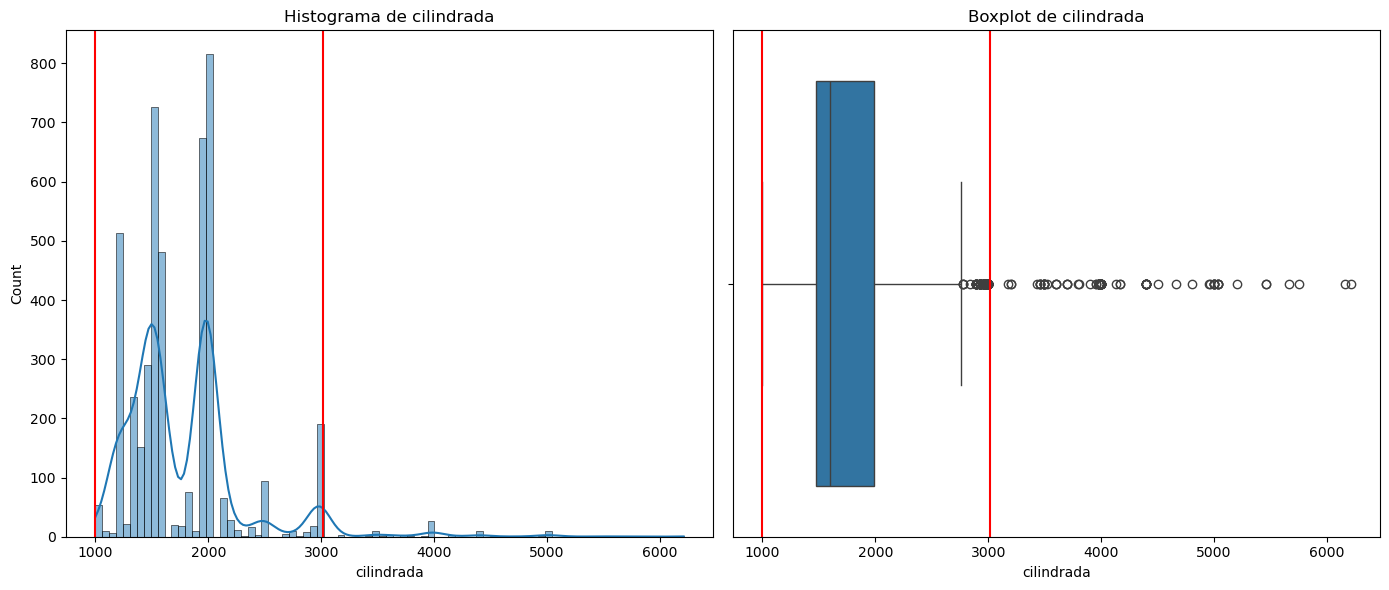

In [20]:
prueba_outliers_tukey('cilindrada', 'derecho', 2)

Se mantienen el 99.24% de los datos en la columna peso después de eliminar los outliers.


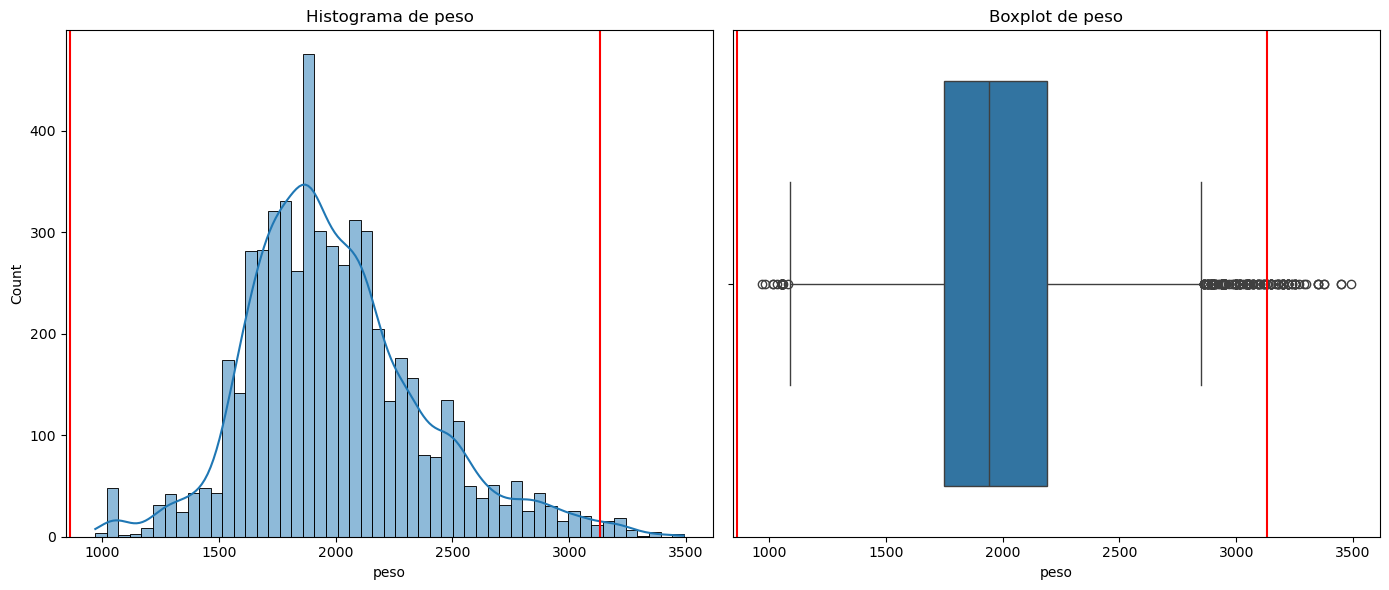

In [21]:
prueba_outliers_z('peso')

In [22]:
df_sin_outliers = outliers_tukey(df_sin_outliers,'kilometraje', 'derecho', 2)
df_sin_outliers = outliers_tukey(df_sin_outliers,'garantia', 'derecho', 3)
df_sin_outliers = outliers_tukey(df_sin_outliers,"potencia_cv", 'derecho', 4)
df_sin_outliers = outliers_tukey(df_sin_outliers,"cilindrada", 'derecho', 2)

Se mantienen el 98.40% de los datos en la columna kilometraje después de eliminar los outliers.
Se mantienen el 96.88% de los datos en la columna garantia después de eliminar los outliers.
Se mantienen el 95.72% de los datos en la columna potencia_cv después de eliminar los outliers.
Se mantienen el 95.02% de los datos en la columna cilindrada después de eliminar los outliers.


In [23]:
df_sin_outliers = outliers_z_score(df_sin_outliers,'precio_contado',3)
df_sin_outliers = outliers_z_score(df_sin_outliers,'batalla',3)
df_sin_outliers = outliers_z_score(df_sin_outliers,'capacidad_maletero',3)
df_sin_outliers = outliers_z_score(df_sin_outliers,'velocidad_max',3)
df_sin_outliers = outliers_z_score(df_sin_outliers,'peso',3)

Se mantienen el 93.46% de los datos en la columna precio_contado después de eliminar los outliers.
Se mantienen el 92.98% de los datos en la columna batalla después de eliminar los outliers.
Se mantienen el 92.06% de los datos en la columna capacidad_maletero después de eliminar los outliers.
Se mantienen el 91.82% de los datos en la columna velocidad_max después de eliminar los outliers.
Se mantienen el 91.27% de los datos en la columna peso después de eliminar los outliers.


## Imputación de nulos

In [25]:
#Calcular en porcentaje de nulos
stats = []
for col in df_sin_outliers.columns:
    stats.append((col, df_sin_outliers[col].nunique(), df_sin_outliers[col].isnull().sum() * 100 / df_sin_outliers.shape[0], df_sin_outliers[col].value_counts(normalize=True, dropna=False).values[0] * 100, df_sin_outliers[col].dtype))
    stats_df = pd.DataFrame(stats, columns=['Columna', 'Valores únicos', '% nulos', '% of values in the biggest category', 'tipo'])
stats_df.sort_values('% nulos', ascending=False)

,Columna,Valores únicos,% nulos,% of values in the biggest category,tipo
23,cilindrada,149,28.646629,28.646629,float64
20,deposito,71,23.908983,23.908983,float64
22,num_cilindros,4,23.280693,47.953812,float64
28,velocidad_max,110,19.969435,19.969435,float64
15,capacidad_maletero,305,19.782646,19.782646,float64
29,aceleracion,126,19.731703,19.731703,float64
27,par,178,19.527933,19.527933,float64
14,alto,335,18.101545,18.101545,float64
12,largo,574,18.050603,18.050603,float64
18,batalla,270,18.016641,18.016641,float64


In [26]:
#Funcion Imputacion de datos

def imputar_datos(df):
    
    #Inicializar Knn para las columnas numericas
    knn_imputer = KNNImputer(n_neighbors=10)
    
    #Aplicar knn imputer a las columnas numericas
    df_numericas = df[columnas_numericas]
    df_imputado_numericas = knn_imputer.fit_transform(df_numericas)
    
    #Convertir los datos imputados a df
    df_imputado_numericas = pd.DataFrame(df_imputado_numericas, columns=columnas_numericas, index=df.index)
    
    #Inicializar SimpleImputer para las columnas categoricas
    simple_imputer = SimpleImputer(strategy='most_frequent')
    
    #Aplicar SimpleImputer para las columnas categoricas
    df_categoricas = df[columnas_categoricas]
    df_imputado_categoricas = simple_imputer.fit_transform(df_categoricas)
    
    #Convertir las columnas categoricas imputadas a df
    df_imputado_categoricas = pd.DataFrame(df_imputado_categoricas,columns=columnas_categoricas, index=df.index)
    
    #Combinamos los datos imputados
    df_imputado = pd.concat([df_imputado_numericas, df_imputado_categoricas], axis =1)
    
    #verificamos que no hay valores nulos
    print(df_imputado.isnull().sum())
    
    return df_imputado

In [27]:
#Imputacion de datos
df_sin_nulos = imputar_datos(df_sin_outliers)

mes_matriculacion       0
ano_matriculacion       0
kilometraje             0
garantia                0
precio_contado          0
largo                   0
ancho                   0
alto                    0
capacidad_maletero      0
batalla                 0
peso                    0
deposito                0
num_cilindros           0
cilindrada              0
num_marchas             0
potencia_cv             0
par                     0
velocidad_max           0
aceleracion             0
provincia               0
comunidad_autonoma      0
concesionario           0
distintivo_ambiental    0
combustible             0
tipo_cambio             0
tipo_traccion           0
marca                   0
modelo                  0
num_plazas              0
num_puertas             0
dtype: int64


## Transformaciones

In [29]:
df_transformado = df_sin_nulos

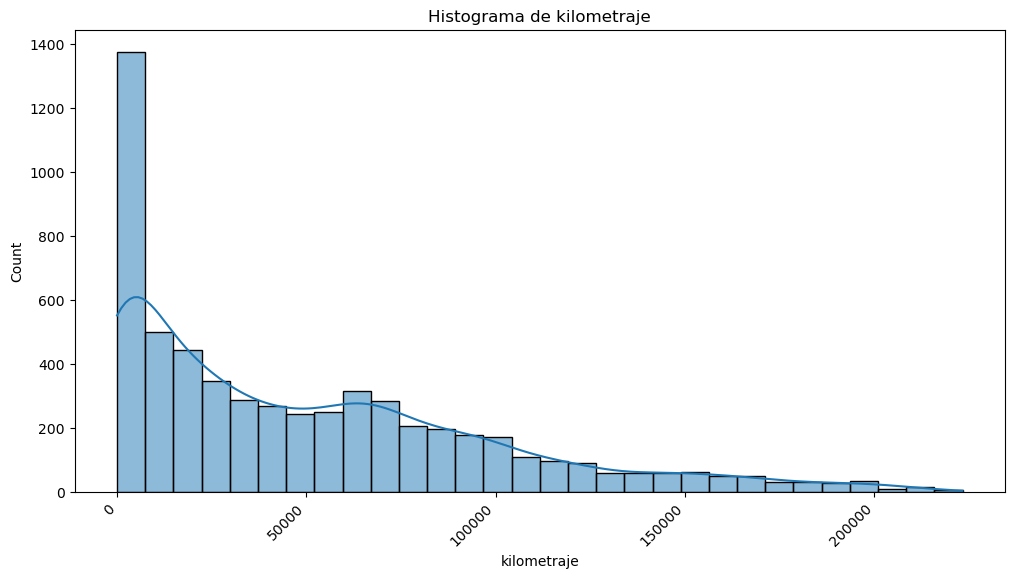

In [30]:
plt.figure(figsize=(12, 6))
sns.histplot(df_sin_nulos['kilometraje'], kde=True)
plt.title('Histograma de kilometraje')
plt.xlabel('kilometraje')
plt.xticks(rotation=45, ha='right')
plt.show()

In [31]:
# Aplicamos transformación logarítmica a kilometraje para que no afecte tanto la varianza de los datos

df_transformado['log_kilometraje'] = np.log(df_transformado['kilometraje'])

In [32]:
# Creamos métricas derivadas de los datos que ya tenemos para reducir el número de columnas

df_transformado['volumen'] = df_transformado['largo'] * df_transformado['ancho'] * df_transformado['alto']

In [33]:
# Creamos la columna fecha_matriculacion para calcular la antigüedad del coche en años

df_transformado['fecha_matriculacion'] = (
    '01/' + df_transformado['mes_matriculacion'].astype(int).astype(str) + 
    '/' + df_transformado['ano_matriculacion'].astype(int).astype(str)
)
df_transformado['fecha_matriculacion'] = pd.to_datetime(df_transformado['fecha_matriculacion'], format='%d/%m/%Y')
current_date = pd.to_datetime(datetime.now())

df_transformado['antiguedad_coche'] = ((current_date - df_transformado['fecha_matriculacion']).dt.days / 365.25).round(2)

In [34]:
# Eliminamos las columnas a las que sustituyen las transformaciones

df_transformado = df_transformado.drop(columns=['largo', 'ancho', 'alto', 'mes_matriculacion', 'fecha_matriculacion', 'kilometraje'])

In [35]:
df_transformado.head()

,ano_matriculacion,garantia,precio_contado,capacidad_maletero,batalla,peso,deposito,num_cilindros,cilindrada,num_marchas,potencia_cv,par,velocidad_max,aceleracion,provincia,comunidad_autonoma,concesionario,distintivo_ambiental,combustible,tipo_cambio,tipo_traccion,marca,modelo,num_plazas,num_puertas,log_kilometraje,volumen,antiguedad_coche
0,2019.0,12.0,20950.0,355.0,2548.0,1855.0,40.0,4.0,1984.0,6.0,200.0,320.0,237.0,6.70,Madrid,Madrid,COCHES AMB,C,Gasolina,Automático,delantera,Volkswagen,POLO,5.0,5.0,11.440355,1.036843e+10,5.16
2,2017.0,12.0,15900.0,460.0,2680.0,1878.0,50.0,4.0,1395.0,6.0,110.0,200.0,195.0,10.90,Murcia,Murcia,SKOMOVIL MURCIA,ECO,Gasolina/gas,Manual,delantera,Skoda,OCTAVIA,5.0,5.0,10.698740,1.235127e+10,7.32
3,2024.0,12.0,24900.0,404.8,2625.9,1888.1,50.1,3.7,1442.0,5.2,110.0,223.2,181.5,10.66,Murcia,Murcia,SKOMOVIL MURCIA,C,Gasolina,Automático,delantera,Skoda,KAMIQ,5.0,5.0,9.268609,1.212990e+10,0.74
4,2024.0,12.0,33500.0,362.7,2644.9,1987.5,46.2,3.7,1782.5,5.1,204.0,262.5,188.9,9.01,Murcia,Murcia,SKOMOVIL MURCIA,0 EMISIONES,Eléctrico,Automático,delantera,Skoda,OCTAVIA,5.0,5.0,9.523178,1.240333e+10,0.82
5,2024.0,12.0,19500.0,332.7,2526.4,1563.5,38.5,3.4,1166.6,4.5,95.0,132.7,171.4,13.04,Murcia,Murcia,SKOMOVIL MURCIA,C,Gasolina,Manual,delantera,Skoda,SCALA,5.0,5.0,1.098612,1.023469e+10,0.91


## Encoding

In [37]:
#Calcular en porcentaje de nulos
stats = []
for col in df_transformado.columns:
    stats.append((col, df_transformado[col].nunique(), df_transformado[col].isnull().sum() * 100 / df_transformado.shape[0], df_transformado[col].value_counts(normalize=True, dropna=False).values[0] * 100, df_transformado[col].dtype))
    stats_df = pd.DataFrame(stats, columns=['Columna', 'Valores únicos', '% nulos', '% of values in the biggest category', 'tipo'])
stats_df.sort_values('% nulos', ascending=False)

,Columna,Valores únicos,% nulos,% of values in the biggest category,tipo
0,ano_matriculacion,27,0.0,21.701477,float64
1,garantia,188,0.0,63.355408,float64
26,volumen,1949,0.0,1.103753,float64
25,log_kilometraje,4130,0.0,3.073527,float64
24,num_puertas,4,0.0,88.605875,object
23,num_plazas,4,0.0,93.496349,object
22,modelo,375,0.0,3.582951,object
21,marca,45,0.0,10.273391,object
20,tipo_traccion,4,0.0,85.107828,object
19,tipo_cambio,2,0.0,56.580065,object


In [38]:
#Aplica los encoders y los guarda en archivos pickle.
def aplicar_encoders(df_transformado,col, encoder):
    
    # Crear la carpeta si no existe 
    os.makedirs('encoders/', exist_ok=True)  
        
    if encoder == 'label encoder':
        
        encoder = LabelEncoder()
        df_transformado[col] = encoder.fit_transform(df_transformado[col].values)
        
    elif encoder == 'target encoder':
        encoder = ce.TargetEncoder()
        df_transformado[col] = encoder.fit_transform(df_transformado[col], df_transformado['precio_contado'])
        
    elif encoder == 'frequency encoder':
        frequency_encoding = df_transformado[col].value_counts().to_dict()
        df_transformado[col] = df_transformado[col].map(frequency_encoding)
        
    else: 
        print('La columna no existe o no has seleccionado el encoder correctamente. Las opciones son:\n'
              '  - label encoder\n'
              '  - target encoder\n'
              '  - frequency encoder')
        
        # Guardar el encoder en un archivo pickle
    with open(os.path.join('encoders/', f"{col}_encoder.pickle"), "wb") as file:
        pickle.dump(encoder, file)
        
    print(f'Encoder aplicado a {col}')
    
    return df_transformado

In [39]:
df_encoded = aplicar_encoders(df_transformado, 'provincia', 'frequency encoder')

df_encoded = aplicar_encoders(df_transformado, 'comunidad_autonoma', 'target encoder')

df_encoded = aplicar_encoders(df_transformado, 'concesionario', 'target encoder')

df_encoded = aplicar_encoders(df_transformado, 'tipo_cambio', 'label encoder')

df_encoded = aplicar_encoders(df_transformado, 'marca', 'target encoder')

df_encoded = aplicar_encoders(df_transformado, 'modelo', 'target encoder')

Encoder aplicado a provincia
Encoder aplicado a comunidad_autonoma
Encoder aplicado a concesionario
Encoder aplicado a tipo_cambio
Encoder aplicado a marca
Encoder aplicado a modelo


In [40]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
with open(os.path.join('encoders/', f"combustible_traccion_distintivo_encoder.pickle"), "wb") as file:
        pickle.dump(encoder, file)


In [41]:
encoded_combustible = encoder.fit_transform(df_encoded[['combustible']])
encoded_combustible_df = pd.DataFrame(encoded_combustible, columns=encoder.get_feature_names_out(['combustible']), index=df_encoded.index)

df_encoded = pd.concat([df_encoded, encoded_combustible_df], axis=1)

In [42]:
one_hot_columns = list(encoded_combustible_df.columns)

In [43]:
encoded_traccion = encoder.fit_transform(df_encoded[['tipo_traccion']])
encoded_traccion_df = pd.DataFrame(encoded_traccion, columns=encoder.get_feature_names_out(['tipo_traccion']), index=df_encoded.index)

df_encoded = pd.concat([df_encoded, encoded_traccion_df], axis=1)

In [44]:
one_hot_columns.extend(list(encoded_traccion_df.columns))

In [45]:
encoded_dist = encoder.fit_transform(df_encoded[['distintivo_ambiental']])
encoded_dist_df = pd.DataFrame(encoded_dist, columns=encoder.get_feature_names_out(['distintivo_ambiental']), index=df_encoded.index)

df_encoded = pd.concat([df_encoded, encoded_dist_df], axis=1)

In [46]:
one_hot_columns.extend(list(encoded_dist_df.columns))

In [47]:
df_encoded = df_encoded.drop(columns=['tipo_traccion', 'combustible', 'distintivo_ambiental'])

In [48]:
df_encoded

,ano_matriculacion,garantia,precio_contado,capacidad_maletero,batalla,peso,deposito,num_cilindros,cilindrada,num_marchas,potencia_cv,par,velocidad_max,aceleracion,provincia,comunidad_autonoma,concesionario,tipo_cambio,marca,modelo,num_plazas,num_puertas,log_kilometraje,volumen,antiguedad_coche,combustible_Eléctrico,combustible_Gas,combustible_Gasolina,combustible_Gasolina/gas,combustible_Híbrido Enchufable,tipo_traccion_total conectable,tipo_traccion_total permanente,tipo_traccion_trasera,distintivo_ambiental_B,distintivo_ambiental_C,distintivo_ambiental_ECO
0,2019.0,12.0,20950.0,355.0,2548.0,1855.0,40.0,4.0,1984.0,6.0,200.0,320.0,237.0,6.70,2112,25949.158144,27174.956041,0,25490.224409,17542.724128,5.0,5.0,11.440355,1.036843e+10,5.16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2017.0,12.0,15900.0,460.0,2680.0,1878.0,50.0,4.0,1395.0,6.0,110.0,200.0,195.0,10.90,119,28411.079861,26577.147057,1,25630.637306,26248.975405,5.0,5.0,10.698740,1.235127e+10,7.32,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2024.0,12.0,24900.0,404.8,2625.9,1888.1,50.1,3.7,1442.0,5.2,110.0,223.2,181.5,10.66,119,28411.079861,26577.147057,0,25630.637306,24261.243253,5.0,5.0,9.268609,1.212990e+10,0.74,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2024.0,12.0,33500.0,362.7,2644.9,1987.5,46.2,3.7,1782.5,5.1,204.0,262.5,188.9,9.01,119,28411.079861,26577.147057,0,25630.637306,26248.975405,5.0,5.0,9.523178,1.240333e+10,0.82,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2024.0,12.0,19500.0,332.7,2526.4,1563.5,38.5,3.4,1166.6,4.5,95.0,132.7,171.4,13.04,119,28411.079861,26577.147057,1,25630.637306,23772.286618,5.0,5.0,1.098612,1.023469e+10,0.91,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6444,2023.0,12.0,25500.0,278.0,2567.0,1740.0,40.0,3.0,1499.0,7.0,136.0,220.0,207.0,8.30,2112,25949.158144,30216.632456,0,24810.371844,30700.488134,5.0,5.0,10.338511,9.900502e+09,1.91,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6446,2017.0,12.0,17900.0,513.0,2670.0,1925.0,62.0,4.0,1685.0,7.0,141.0,280.0,185.0,13.70,2112,25949.158144,25585.654701,0,22828.524794,26788.301639,5.0,5.0,11.870600,1.374272e+10,7.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6447,2017.0,12.0,8999.0,555.0,2660.0,2245.0,56.0,4.0,2494.0,1.0,197.0,210.0,193.6,9.30,140,26653.572337,24793.214807,0,38650.207422,32209.272765,5.0,5.0,11.825281,1.405217e+10,7.41,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6449,2019.0,12.0,27999.0,530.0,2975.0,2270.0,66.0,4.0,1995.0,8.0,190.0,400.0,235.0,7.30,15,29797.375422,27265.275819,0,33409.392290,29068.330780,5.0,4.0,12.089539,1.363704e+10,5.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## Escalar datos

In [50]:
#Crear una carpeta para guardar el objeto escalador
os.makedirs("escaladores", exist_ok=True)

In [51]:
x = df_encoded.drop('precio_contado', axis=1)  
y = df_encoded['precio_contado']

In [52]:
cols_x = list(x.columns)

In [53]:
# Creamos los scalers, escalamos los datos y guardamos el scaler en un archivo .pickle

x_scaler = StandardScaler()
x = x_scaler.fit_transform(x)
nombre_pickle_x = "x_scaler.pickle"
ruta_completa_x = os.path.join("escaladores/", nombre_pickle_x)
with open(ruta_completa_x, "wb") as file:
    pickle.dump(x_scaler, file)

y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))
nombre_pickle_y = "y_scaler.pickle"
ruta_completa_y = os.path.join("escaladores/", nombre_pickle_y)
with open(ruta_completa_y, "wb") as file:
    pickle.dump(y_scaler, file)


In [54]:
x_df = pd.DataFrame(x, columns=cols_x) 
y_df = pd.DataFrame(y, columns=['precio_contado'])

df_escalado = pd.concat([x_df, y_df], axis=1)

In [55]:
df_escalado.head()

,ano_matriculacion,garantia,capacidad_maletero,batalla,peso,deposito,num_cilindros,cilindrada,num_marchas,potencia_cv,par,velocidad_max,aceleracion,provincia,comunidad_autonoma,concesionario,tipo_cambio,marca,modelo,num_plazas,num_puertas,log_kilometraje,volumen,antiguedad_coche,combustible_Eléctrico,combustible_Gas,combustible_Gasolina,combustible_Gasolina/gas,combustible_Híbrido Enchufable,tipo_traccion_total conectable,tipo_traccion_total permanente,tipo_traccion_trasera,distintivo_ambiental_B,distintivo_ambiental_C,distintivo_ambiental_ECO,precio_contado
0,-0.514653,-0.61155,-0.747108,-0.982699,-0.340525,-1.195931,0.528045,0.966957,0.058727,0.718148,0.416949,2.000276,-1.419694,1.308848,-0.62340,-0.001093,-0.876018,-0.200907,-1.279397,0.060062,0.320727,0.678315,-1.245719,0.424386,-0.272476,-0.018432,1.065115,-0.077323,-0.410994,-0.072746,-0.327993,-0.220902,-0.178073,0.756080,-0.518299,-0.465399
1,-1.079678,-0.61155,0.303760,0.135480,-0.268818,-0.081441,0.528045,-0.679817,0.058727,-0.729933,-0.725943,-0.045944,0.637860,-0.887711,0.66532,-0.094086,1.141529,-0.183522,-0.091172,0.060062,0.320727,0.441055,0.046937,1.035776,-0.272476,-0.018432,-0.938866,12.932793,-0.410994,-0.072746,-0.327993,-0.220902,-0.178073,-1.322611,1.929387,-0.844137
2,0.897908,-0.61155,-0.248696,-0.322804,-0.237330,-0.070296,-0.017063,-0.548411,-0.375068,-0.729933,-0.504984,-0.703658,0.520286,-0.887711,0.66532,-0.094086,-0.876018,-0.183522,-0.362457,0.060062,0.320727,-0.016478,-0.097380,-0.826697,-0.272476,-0.018432,1.065115,-0.077323,-0.410994,-0.072746,-0.327993,-0.220902,-0.178073,0.756080,-0.518299,-0.169159
3,0.897908,-0.61155,-0.670044,-0.161854,0.072566,-0.504947,-0.017063,0.403587,-0.429293,0.782507,-0.130687,-0.343133,-0.288039,-0.887711,0.66532,-0.094086,-0.876018,-0.183522,-0.091172,0.060062,0.320727,0.064965,0.080872,-0.804053,3.670053,-0.018432,-0.938866,-0.077323,-0.410994,-0.072746,-0.327993,-0.220902,-0.178073,-1.322611,-0.518299,0.475819
4,0.897908,-0.61155,-0.970292,-1.165674,-1.249325,-1.363104,-0.562170,-1.318397,-0.754639,-0.971280,-1.366916,-1.195725,1.686233,-0.887711,0.66532,-0.094086,1.141529,-0.183522,-0.429189,0.060062,0.320727,-2.630252,-1.332908,-0.778578,-0.272476,-0.018432,1.065115,-0.077323,-0.410994,-0.072746,-0.327993,-0.220902,-0.178073,0.756080,-0.518299,-0.574146


In [56]:
#Guardar el DataFrame con las columnas transformadas
df_escalado.to_csv('../bin/data_process.csv', index=False)